<span id="head"></span>

## Workflow

<img src="/data/tzeshinchen/deep_learning/transformer/Ai_meeting/image/workflow.jpg" alt="Transformers_workflow" width="1200">

<li><a href="#1">1. Embedding</a></li>
<li><a href=#2>2. Positional Encoding</a></li>
<li><a href="#3">3. Multi-Head Attention</a></li>
<li><a href="#4">4. SubLayer</a></li>
<li><a href="#5">5. Feedfoeard</a></li>
<li><a href="#6">6. Encoder Layer</a></li>
<li><a href="#7">7. Decoder Layer</a></li>
<li><a href="#8">8. Layernorm</a></li>
<li><a href="#9">9. Encoder</a></li>
<li><a href="#10">10. Decoder</a></li>
<li><a href="#11">11. Generator</a></li>
<li><a href="#12">12. EncoderDecoder</a></li>
<li><a href="#Final">Final</a></li>

In [1]:
import torch
print(torch.__version__)

2.0.0+cu117


# Import 

In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
# 在最後可視化attention的時候會用到
import matplotlib.pyplot as plt
import seaborn
# seaborn.set_context(context="talk")
# %matplotlib inline

## Seq-Seq傳統模型架構 transformer也遵循這個架構

In [9]:
class EncoderDecoder(nn.Module):
    # 這是標準的Encoder-Decoder架構
    def __init__(self, encoder , decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def encoder(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decoder(self, tgt, memory, src_mask, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [10]:
class Generator(nn.Module):
    # 定義standard linear + softmax generation step
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

<span id="1"></span>

## 進入到transformers 
## 1. Embedding
<a href="#head">Back</a>

In [11]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        # vocab = 當前語言的字典大小
        # nn.Module是將參數打包成一個物件當執行forward可以自動做gradient
        super(Embeddings, self).__init__()
        self.d_model = d_model # size = 512
        self.lut = nn.Embedding(vocab, d_model)
        # 將vocab大小的字典轉成d_model大小(512)的向量
        # 產生第一個weight matrix大小為vocab*d_model
    def forward(self, x):
        # x = [batch_size, seq_len, one-hot==vocab]
        # 不知道為什麼要乘以math.sqrt(self.d_model)
        return self.lut(x)*math.sqrt(self.d_model)
    
    

<span id="2"></span><span id="2"></span>


## 2.Positional Encoding
<a href="#head">Back</a>

In [12]:
class PositionalEncoding(nn.Module): 
  "Implement the PE function." 
  def __init__(self, d_model, dropout, max_len=5000): 
    #d_model=512,dropout=0.1,
    #max_len=5000 先定義好長度為5000的位置編碼  
    super(PositionalEncoding, self).__init__() 
    self.dropout = nn.Dropout(p=dropout) 

    # Compute the positional encodings once in log space. 
    pe = torch.zeros(max_len, d_model) 
    # (5000, 512)矩陣，保持每個位置的位置編碼，一共5000個位置，
    # 每個位置用一個512dim向量來表示其位置編碼。
    position = torch.arange(0, max_len).unsqueeze(1) 
    # (5000) -> (5000,1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * 
      -(math.log(10000.0) / d_model)) 
      # (0,2,…, 4998)一共準備2500个值，供sin, cos调用
    pe[:, 0::2] = torch.sin(position * div_term) # even index sin
    pe[:, 1::2] = torch.cos(position * div_term) # odd index cos
    pe = pe.unsqueeze(0) 
    # (5000, 512) -> (1, 5000, 512) 為batch.size留出位置
    self.register_buffer('pe', pe) 
  def forward(self, x): 
    x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False) 
  # 接受1.Embeddings的詞嵌入結果x，
  # 然後將自己的位置編碼pe，封裝成torch的Variable（不需要梯度），加上去。
  # 例如，假設x是(30,10,512)的一個tensor，
  # 30是batch.size，10是該batch的序列長度，512是每個詞的詞嵌入向量；
  # 則該行程式碼的第二項是(1, min(10, 5000), 512)=(1,10,512)，
  # 在具體相加的時候，會擴展(1,10,512)為(30,10,512)，
  # 保證一個batch中的30個序列，都使用（疊加）一樣的位置編碼。

    return self.dropout(x) # 增加一次dropout操作


In [13]:
# class A(object):
#     def __init__(self):
#         print(self.__class__.__mro__)

#     def bark(self):
#         super(A, self).bark()
#         print("I'm A")

# class B(object):
#     def bark(self):
#         print("I'm B")


# class C(A, B):
#     def bark(self):
#         print("I'm C")
#         super(C, self).bark()


# if __name__ == '__main__':
#     c = C()
#     c.bark()



In [14]:
# # 要怎麼把1.Embeddings和2.PositionalEncoding串起來
# nn.Sequential(Embeddings(d_model,src_vocab),
#   PositionalEncoding(d_model,dropout)) 
# # 這樣就可以了，因為nn.Sequential可以接受一系列的nn.Module，然後按順序执行。

<span id="3"></span>

## 3.Multi-Head Attention
<a href="#head">Back</a>

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [1]:
class attention():
    pass

<img src="/data/tzeshinchen/deep_learning/transformer/Ai_meeting/image/Multi-Head.png" alt="Multi-head" width="700">



In [ ]:
class MultiHeadedAttention(nn.Module): 
  def __init__(self, h, d_model, dropout=0.1): 
    # h(head)=8, d_model(文字轉換成512dim)=512
    super(MultiHeadedAttention, self).__init__() 
    assert d_model % h == 0 # We assume d_v always equals d_k 512%8=0
    self.d_k = d_model // h # d_k=512/8=64
    self.h = h #8
    self.linears = clones(nn.Linear(d_model, d_model), 4) 
    # 做四次Linear Networks，每次的輸入和輸出都是d_model=512，
    # 其實就是
    # Q = nn.Linear(d_model, d_model)
    # K = nn.Linear(d_model, d_model)
    # V = nn.Linear(d_model, d_model)
    # O = nn.Linear(d_model, d_model)
    #https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
     
    self.attn = None 
    self.dropout = nn.Dropout(p=dropout)
  def forward(self, query, key, value, mask=None): 
    # Q, K, V 在encoder(30, 10, 512)，
    # 30代表當前batch的大小
    # 10 代表當前batch中每個句子的長度(是固定10的長度)
  
    # if mask is not None: # Same mask applied to all h heads. 
    #   mask = mask.unsqueeze(1)
    #   nbatches = query.size(0) # nbatches=30
      
    # 1) Do all the linear projections in batch from 
    #d_model => h x d_k 
    query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))] 
    # 這裡是前三個nn.Linear的具體應用，
    # 例如query=(30,10, 512) -> Linear network -> (30, 10, 512) 
    # -> view -> (30,10, 8, 64) -> transpose(1,2) -> (30, 8, 10, 64)
    # ，其他的key和value也是類似地，
    # 從(30, 10, 512) -> (30, 8, 10, 64)。
    
    # 2) Apply attention on all the projected vectors in batch. 
    x, self.attn = attention(query, key, value, mask=mask, 
      dropout=self.dropout) 
    # 調用上面定義好的attention函數，輸出的x形狀為(30, 8, 10, 64)；
    # attn的形狀為(30, 8, 10=target.seq.len, 11=src.seq.len)
    
    # 3) "Concat" using a view and apply a final linear.
    x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k) 
      # x ~ (30, 8, 10, 64) -> transpose(1,2) -> 
      #(30, 10, 8, 64) -> contiguous() and view -> 
      #(30, 10, 8*64) = (30, 10, 512)
    return self.linears[-1](x) 
    # 執行第四個Linear network，將(30, 10, 512)通過一次linear


In [6]:
import torch
a=torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8])
print(a.view(4,2))

tensor([[1., 2.],
        [3., 4.],
        [5., 6.],
        [7., 8.]])


In [2]:
# EX : zip
a = [1, 2, 3, 4]
b = [4,5,6]
c = [4,5,6,7,8]
zipped = zip(a, b)
zipped1 = zip(a,(b, c))
print(list(zipped))
print(list(zipped1))

[(1, 4), (2, 5), (3, 6)]
[(1, [4, 5, 6]), (2, [4, 5, 6, 7, 8])]


In [6]:
# Ex : view transpose 
# query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))] 
import torch
import torch.nn as nn
import copy 

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

query = torch.randn(30, 10, 512)
key =torch.randn(30, 10, 512)
value= torch.randn(30, 10, 512)
d_model = 512
nbatches = 30 #batch size 
h = 8 #number of heads
d_k = 64 #512//8=64
Linears = clones(nn.Linear(d_model, d_model), 4) 

query, key, value = [l(x).view(nbatches, -1, h, d_k)
    .transpose(1, 2) for l, x in 
    zip(Linears, (query, key, value))] 

In [ ]:
def attention(query, key, value, mask=None, dropout=None): 
# query、key、value的形狀類似於(batch_size, 目標序列中詞語個數, head數, 嵌入維度)
# (30, 8, 10, 64)
# 30代表當前batch的大小
# 8代表attention head的數量
# 10代表序列長度，EX：<start> I am a student study in NYCU . <end>
# 64代表每個詞向量的維度大小。

  "Compute 'Scaled Dot Product Attention'" 
  d_k = query.size(-1) # 64=d_k
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # 先是(30,10,6,64)和(30, 10, 6, 64)相乘，
    # Q x K 得到(30, 8, 10, 10)，

  # if mask is not None: 
  #   scores = scores.masked_fill(mask == 0, -1e9) 
  #使用遮罩，對已經計算好的分數，在遮罩矩陣上填充-1e9，
  #接下來在計算softmax時，被設置為-1e9的數值會被忽略，相當於該位置沒有對應的信息
  p_attn = F.softmax(scores, dim = -1) 
    #(30, 8, 10, 10)
  if dropout is not None: 
    p_attn = dropout(p_attn) #執行dropout
  return torch.matmul(p_attn, value), p_attn
  # 返回的第一项是 (30,8,10,10) 乘以（最后两个维度相乘）后得到的 tensor，形状为 (30,8,10,64)，和 query 最初的形状一样。同时，返回的 p_attn 形状为 (30,8,10,10)。


In [17]:
y = torch.randn(30, 8, 10, 10)
x = torch.randn(30, 8, 10, 64)
torch.matmul(y, x).shape

torch.Size([30, 8, 10, 64])

In [7]:
print(query.size())

torch.Size([30, 8, 10, 64])


<span id="4"></span>


## 4.Sublayer
<a href="#head">Back</a>

<img src="/data/tzeshinchen/deep_learning/transformer/Ai_meeting/image/layernorm.png">

In [ ]:
# go to encoder layer first 

In [ ]:
class LayerNorm(nn.Module):
    pass


In [ ]:
class SublayerConnection(nn.Module):
    # 做add

    def __init__(self, size, dropout):
        # size=d_model=512; dropout=0.1
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size) # (512)，用来定义a_2和b_2
        self.dropout = nn.Dropout(dropout)
# x 
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the "
        "same size."
        
        # x is alike (batch.size, sequence.len, 512)

        return x + self.dropout(sublayer(self.norm(x)))
        # x (30, 10, 512) -> norm (LayerNorm) -> (30, 10, 512)
        # -> sublayer (MultiHeadAttention or PositionwiseFeedForward)
        # -> (30, 10, 512) -> dropout -> (30, 10, 512)
        
        # 然後輸入的x（没有走sublayer) + 上面的结果，
        #實現Add & Norm


## 5.FeedForward
<a href="#head">Back</a>

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        # d_model = 512
        # d_ff = 2048 = 512*4
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        # 構建第一個全連接層，(512, 2048)，其中有兩種可訓練參數：
        # weights矩陣，(512, 2048)，以及
        # biases偏移向量, (2048)
        self.w_2 = nn.Linear(d_ff, d_model)
        # 構建第二個全連接層, (2048, 512)，兩種可訓練參數：
        # weight矩陣，(2048, 512)，以及
        # biases偏移向量, (512)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape = (batch.size, sequence.len, 512)
        # 例如, (30, 10, 512)
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
        # x (30, 10, 512) -> self.w_1 -> (30, 10, 2048)
        # -> relu -> (30, 10, 2048) 
        # -> dropout -> (30, 10, 2048)
        # -> self.w_2 -> (30, 10, 512)是輸出的shape

<span id="5"></span>


## 6.Encoder Layer*N
<a href="#head">Back</a>


In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and "
    "feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        # size=d_model=512
        # self_attn = MultiHeadAttention, first sublayer input 資訊在final 裡面
        # feed_forward = PositionwiseFeedForward，second sublayer
        # dropout = 0.1 (e.g.)
        super(EncoderLayer, self).__init__()
        self.size = size # 512
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # 直接copy兩個SublayerConnection對象，分別對應multi-head attention , feed forward兩個output

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # x shape = (30, 10, 512)
        # mask 是(batch.size, 10,10)的矩陣，類似於當前一個詞w，有哪些詞是w可見的
        # 源語言的序列的話，所有其他詞都可見，除了"<blank>"這樣的填充；
        # 目標語言的序列的話，所有w的左邊的詞，都可見。
        
        # query_init, key init, value init= x, x, x
        x = self.sublayer[0](x,lambda x: self.self_attn(x, x, x, mask))
        # 輸入x和self_attention的output一起，给第一個SublayerConnection
        # lambda x: self.self_attn(x, x, x, mask) = 
        # def lambda(x):
        #   return self.self_attn(x, x, x, mask)
        # 就被更新
        
        # x (30, 10, 512) -> self_attn (MultiHeadAttention) 
        # shape is same (30, 10, 512) -> SublayerConnection 
        # -> (30, 10, 512)
        return self.sublayer[1](x, self.feed_forward)
        # x 和feed_forward對象一起，给第二個SublayerConnection output = (30, 10, 512)

<span id="6"></span>


## 7.Decoder Layer*N
<a href="#head">Back</a>

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, "
    "and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, 
      feed_forward, dropout):
      # size = d_model=512,
      # self_attn = one MultiHeadAttention object，目標語言序列的
      # src_attn = second MultiHeadAttention object, 目標語言序列
      # 和源語言序列之間的
      # feed_forward 一個全連接層
      # dropout = 0.1   
        super(DecoderLayer, self).__init__()
        self.size = size # 512
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        # 需要三個SublayerConnection, 分別在
        # self.self_attn, self.src_attn, 和self.feed_forward的後面

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory # (batch.size, sequence.len, 512) 
        # 來自源語言序列的Encoder之後的輸出，作為memory
        # 供目標語言的序列檢索匹配：（類似於alignment in SMT)
        x = self.sublayer[0](x, 
          lambda x: self.self_attn(x, x, x, tgt_mask))
        # 通過一個匿名函數，來實現目標序列的自註意力編碼
        # 結果扔給sublayer[0]:SublayerConnection
        x = self.sublayer[1](x, 
          lambda x: self.src_attn(x, m, m, src_mask))
        # 通過第二個匿名函數，來實現目標序列和源序列的注意力計算
        # 結果扔給sublayer[1]:SublayerConnection
        return self.sublayer[2](x, self.feed_forward)
        # 走一個全連接層，然後
        # 結果扔給sublayer[2]:SublayerConnection

<span id="7"></span>


## 8.Layernorm
<a href="#head">Back</a>


<img src="/data/tzeshinchen/deep_learning/transformer/Ai_meeting/image/layernorm.png">

In [ ]:
# 0503
# 測self
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        # features=d_model=512, eps=epsilon 用于分母的非0化平滑
        super(LayerNorm, self).__init__()
        
        self.a_2 = nn.Parameter(torch.ones(features))
        # nn.Parameter = https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
        # https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter
        # 可以想像成在做資料型態轉換而已，將定量的資料轉換成定性的資料
        # a_2 是一個weight，(512)
        self.b_2 = nn.Parameter(torch.zeros(features))
        # b_2 也是一個是一個weight, (512)
        self.eps = eps

    def forward(self, x):
        # x = (batch.size, sequence.len, 512)
        mean = x.mean(-1, keepdim=True) 
        # 把x的最後一個維度取平均值，然後得到一個張量 (batch.size, seq.len)。
        std = x.std(-1, keepdim=True)
        # # 对 x 的最后一个维度取標準差，得到形状为 (batch.size, seq.len) 的 tensor。

        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        # 本質上類似於（x-mean)/std，不過這裡加入了兩個可訓練向量 目的是為了平移和縮放
        # a_2 and b_2，以及分母上增加一個極小值epsilon，用來防止std為0的時候的除法溢出。

In [8]:
import torch.nn as nn
print(torch.ones(4))
print(torch.zeros(4))
print(type(torch.ones(4)))
print(type(nn.Parameter(torch.ones(4))))


tensor([1., 1., 1., 1.])
tensor([0., 0., 0., 0.])
<class 'torch.Tensor'>
<class 'torch.nn.parameter.Parameter'>


<span id="8"></span>

In [5]:
# keepmean 做甚麼
# 保留原始維度，不做維度壓縮一個維度變成1
import torch

# x = [[0.6,0.9,0.1,0.4,-0.7,-0.3],[0.5,0.8,-0.1,0.2,-0.6,-0.5],[0.7,-0.1,0.4,0.3,-0.4,-0.1],[-0.8,-0.4,-0.5,0.1,-0.9,0.3]]
# x=torch.tensor(x)
x= torch.randn(30, 10, 512)
mean_x = x.mean(-1, keepdim=True)

print('x shape:', x.shape)
print('mean_x shape:', mean_x.shape)


x shape: torch.Size([30, 10, 512])
mean_x shape: torch.Size([30, 10, 1])


In [7]:
STD = x.std(-1, keepdim=True)
Norm = ((x - mean_x) / (STD+1e-6))
print(Norm.shape)

torch.Size([30, 10, 512])


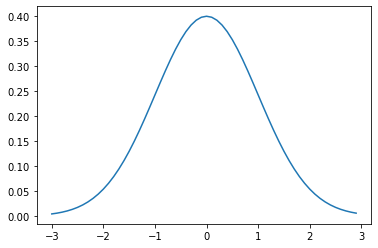

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

x = np.arange(start=-3,stop=3,step=0.1)
y = 1/(math.sqrt(2*math.pi))*math.e**(-x**2/2)
# y1 = 1/math.sqrt(2*math.pi)*math.e**(-1/2*x**2)
plt.plot(x,y)
plt.show()



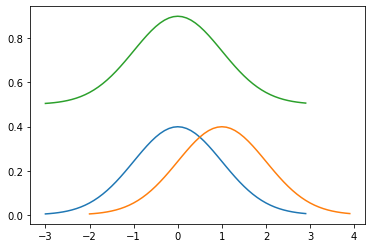

In [96]:
plt.plot(x, y)
new_x=x+1
plt.plot(new_x,y)

new_y=y+0.5
plt.plot(x,new_y)

<span id="9"></span>

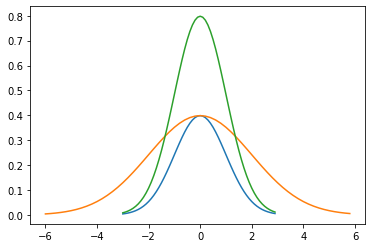

In [98]:
plt.plot(x, y)
new_x=x*2
plt.plot(new_x,y)

new_y=y*2
plt.plot(x,new_y)


## 9.Encoder
<a href="#head">Back</a>


In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        # layer = one EncoderLayer object, N=6
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) 
        # copy，N=6，
        self.norm = LayerNorm(layer.size)
        # 定義一個LayerNorm，layer.size=d_model=512
        # 其中有兩個可訓練參數a_2和b_2

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        # x is alike (30, 10, 512)
        # (batch.size, sequence.len, d_model)
        # mask是類似於(batch.size, 10, 10)的矩陣
        for layer in self.layers:
            x = layer(x, mask)
            # 進行六次EncoderLayer操作
        return self.norm(x)
        # 最後做一次LayerNorm，最後的輸出也是(30, 10, 512) shape

<span id="10"></span>


## 10.Decoder
<a href="#head">Back</a>


In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        # layer = DecoderLayer object
        # N = 6
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        # 深度copy六次DecoderLayer
        self.norm = LayerNorm(layer.size)
        # 初始化一個LayerNorm

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
            # 執行六次DecoderLayer
        return self.norm(x)
        # 執行一次LayerNorm

<span id="11"></span>

## 11.Generator
<a href="#head">Back</a>


In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        # d_model=512
        # vocab = 目標字典大小
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        # 定義一個全連接層，可訓練參數個數是(512 * trg_vocab_size) + trg_vocab_size

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
        # x 類似於 (batch.size, sequence.length, 512)
        # -> proj FFN (30, 10, trg_vocab_size) = logits
        # 對最後一個維度執行log_soft_max得到(30, 10, trg_vocab_size)

<span id="12"></span>


## 12.EncoderDocoder
<a href="#head">Back</a>


In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. 
    Base for this and many other models.
    """
    def __init__(self, encoder, decoder, 
      src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        # Encoder對象
        self.decoder = decoder
        # Decoder對象
        self.src_embed = src_embed
        # 來源語言序列的編碼，包括詞嵌入和位置編碼
        self.tgt_embed = tgt_embed
        # 目標語言序列的編碼，包括詞嵌入和位置編碼
        self.generator = generator
        


    def encode(self, src, src_mask):
        # src = (batch.size, seq.length)
        # src_mask 负责对src加掩码
        return self.encoder(self.src_embed(src), src_mask)
        # 對目標語言序列進行編碼，得到的結果為
        # (batch.size, seq.length, 512)的tensor

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), 
          memory, src_mask, tgt_mask)
      # 對目標語言序列進行編碼，得到的結果為
        # (batch.size, seq.length, 512)的tensor
        
      
    
    # 在這邊吃encoder output
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
        # 先對源語言序列進行編碼，
        # 結果作為memory傳遞給目標語言的編碼器

<span id="Final"></span>

## Final
<a href="#head">Back</a>


In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    # 加copy是為了避免共享參數
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder( 
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N), 
        Decoder(DecoderLayer(d_model, c(attn), c(attn),c(ff), dropout), N),    
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    # d_model=512 attn 呼叫MultiHeadedAttention 傳出output 是一個(30, 10, 512)的tensor(batch.size, seq.length, 512)
    # ff=2048
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [ ]:
# Small example model.
tmp_model = make_model(10, 10, 2)
# src_vocab_size = 10
# tgt_vocab_size = 10
# N = 2, number for EncoderLayer and DecoderLayer

for name, param in tmp_model.named_parameters():
    if param.requires_grad:
        print (name, param.data.shape)
    else:
        print ('no gradient necessary', name, param.data.shape)

In [ ]:
tmp_model = make_model(30000, 30000, 6) 
# src_vocab_size=30000, tgt_vocab_size=30000, N=6
#None
for name, param in tmp_model.named_parameters():
    if param.requires_grad:
        print (name, param.data.shape)
    else:
        print ('no gradient necessary', name, param.data.shape)

In [4]:
# **************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

## Model Training

In [ ]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

## Loop

In [ ]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [ ]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

In [ ]:
def example_learning_schedule():
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

## Regularization

### Label Smoothing

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

In [ ]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

## Optimizer

In [ ]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [ ]:


def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data


def penalization_visualization():
    crit = LabelSmoothing(5, 0, 0.1)
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")

    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )


show_example(penalization_visualization)

## A First  Example

In [ ]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

## Loss Computation

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

## Greedy Decoding

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

In [ ]:
# Train the simple copy task.


def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


# execute_example(example_simple_model)